In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import sys
import random
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from distcorr import distcorr
from scipy.stats import pearsonr

In [103]:
NAN = 0

def fill_nan(array, REPLACE_COUNT):
    array.flat[np.random.choice(array.size, int(REPLACE_COUNT), replace=False)] = NAN

    return array

In [104]:
pd.set_option('display.max_rows', None)
df = pd.read_excel('dutch_census.xls')
df.shape

(6303, 97)

In [105]:
df.columns = df.iloc[1, :]

In [106]:
df = df.drop(df.index[1])
df = df.drop(columns=['Bedrijf en Beroep', 'Telling', 'Tabel', 'Pagina links', 'Pagina rechts', 'Provincie', 'Image nr Links', 'Image nr Rechts'])

In [107]:
df.replace(0, np.nan, inplace=True)
df.shape

(6302, 89)

In [108]:
df = df.dropna(how='all')
df.shape

(5784, 89)

In [109]:
df = df.dropna(axis=1, thresh=df.shape[0]*0.5)
df.shape

(5784, 3)

In [110]:
df = df.drop(df.index[0])

In [111]:
full_df = df.dropna()

In [112]:
array = full_df.to_numpy()

In [115]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

scaled_data = scaler.fit_transform(array)

In [117]:
average_value = np.median(scaled_data.flatten())
average_value

5.887848266224947e-05

In [52]:
full_data = scaled_data.copy()
missing_data = fill_nan(scaled_data, scaled_data.size*0.2)

In [53]:
x_train, x_test, y_train, y_test = train_test_split(missing_data, full_data, random_state=0)

In [94]:
NUM_EPOCHS = 100
LEARNING_RATE = 0.001
BATCH_SIZE = -1
NUM_FEATURES = 3
BATCH_SIZE_TEST = -1

In [55]:
x_train = torch.from_numpy(x_train.astype(float))
#x_train = x_train.to(device)
x_train = x_train.view(BATCH_SIZE, NUM_FEATURES)

y_train = torch.from_numpy(y_train.astype(float))
#y_train = y_train.to(device)
y_train = y_train.view(BATCH_SIZE, NUM_FEATURES)

x_test = torch.from_numpy(x_test.astype(float))
#x_test = x_test.to(device)
x_test = x_test.view(BATCH_SIZE_TEST, NUM_FEATURES)

y_test = torch.from_numpy(y_test.astype(float))
#y_test = y_test.to(device)
y_test = y_test.view(BATCH_SIZE_TEST, NUM_FEATURES)

x_train.shape

torch.Size([1909, 3])

In [95]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.enc1 = nn.Linear(in_features=3, out_features=8)
        self.enc2 = nn.Linear(in_features=8, out_features=16)

        self.dec1 = nn.Linear(in_features=16, out_features=8)
        self.dec2 = nn.Linear(in_features=8, out_features=3)

    def forward(self, x):
        x = F.leaky_relu(self.enc1(x))
        x = F.leaky_relu(self.enc2(x))
        x = F.leaky_relu(self.dec1(x))
        x = self.dec2(x)
        return x

In [96]:
# CREATE A SEED FOR CONSISTENT WEIGHT INITIALIZATIONS - FOR TESTING PURPOSES
random.seed(2)
torch.manual_seed(random.randint(1, 10))
net = Autoencoder().double()
#net.to(device)

In [97]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [98]:
def train(net):
    train_loss = []
    torch.set_printoptions(precision=2, sci_mode=False)
    np.set_printoptions(precision=2, suppress=True)

    for epoch in range(NUM_EPOCHS):
        # running_loss: LOSS OF THE PREDICTED MISSING VALUE ONLY
        # overall_loss: LOSS OF ALL RECONSTRUCTED VALUES

        running_loss = 0.0
        overall_loss = 0.0
        count = 0
        for missing_data, full_data in zip(x_train, y_train):
            optimizer.zero_grad()
            outputs = net(missing_data.double())

            # LEARN FROM LOSS OF ALL RECONSTRUCTED VALUES
            loss = criterion(outputs, full_data)
            loss.backward()
            optimizer.step()
            overall_loss += loss.item()
            
            # COMPUTE LOSS OF PREDICTED MISSING VALUE
            if NAN in missing_data:
                for index in range(len(missing_data)):
                    if missing_data[index] == NAN:
                        predicted_loss = criterion(outputs[index], full_data[index])
                        running_loss += predicted_loss.item()
                        count += 1
            
            # PRINT ALL VALUES ON LAST EPOCH FOR TESTING PURPOSES
            if epoch == NUM_EPOCHS-1:
                if missing_data.detach().numpy().all() == full_data.detach().numpy().all():
                    print("Input: ", scaler.inverse_transform(missing_data.reshape(-1,3)))
                    print("Target: ", scaler.inverse_transform(full_data.reshape(-1,3)))
                    print("Outputs: ", scaler.inverse_transform(outputs.reshape(-1,3).detach().numpy()))
                else:
                    print("Input (missing): ", scaler.inverse_transform(missing_data.reshape(-1,3)))
                    print("Target (missing): ", scaler.inverse_transform(full_data.reshape(-1,3)))
                    print("Outputs (missing): ", scaler.inverse_transform(outputs.reshape(-1,3).detach().numpy()))
        
      #  loss = running_loss / count
        overall_loss = overall_loss / len(x_train)
        x_loss = running_loss / count
        train_loss.append(loss)



        print('Epoch {} of {}, Train Loss: {:.7f}, Overall: {:.7f}'
             .format(epoch+1, NUM_EPOCHS, x_loss, overall_loss))

    return train_loss


def test(net):

    net.eval()
    count = 0

    with torch.no_grad():
        test_loss = []
        running_loss = 0.0
        overall_loss = 0.0

        for missing_data, full_data in zip(x_test, y_test):
            outputs = net(missing_data.double())

            # LEARN FROM LOSS OF ALL RECONSTRUCTED VALUES
            loss = criterion(outputs, full_data)
            overall_loss += loss.item()

            if NAN in missing_data:
                for index in range(len(missing_data)):
                    if missing_data[index] == NAN:
                        predicted_loss = criterion(outputs[index], full_data[index])
                        running_loss += predicted_loss.item()
                        count += 1
            
            if missing_data.detach().numpy().all() == full_data.detach().numpy().all():
                print("Input: ", scaler.inverse_transform(missing_data.reshape(-1,3)))
                print("Target: ", scaler.inverse_transform(full_data.reshape(-1,3)))
                print("Outputs: ", scaler.inverse_transform(outputs.reshape(-1,3).detach().numpy()))
            else:
                print("Input (missing): ", scaler.inverse_transform(missing_data.reshape(-1,3)))
                print("Target (missing): ", scaler.inverse_transform(full_data.reshape(-1,3)))
                print("Outputs (missing): ", scaler.inverse_transform(outputs.reshape(-1,3).detach().numpy()))

        overall_loss = overall_loss / len(x_test)
        x_loss = running_loss / count
        test_loss.append(overall_loss)
        print('Test Loss: {:.7f}, Overall: {:.7f}'.format(x_loss, overall_loss))

        return test_loss

In [99]:
results = train(net)

.92 -150.73]]
Input:  [[149.   1.  72.]]
Target:  [[149.   1.  72.]]
Outputs:  [[ 106.31   32.15 1017.96]]
Input:  [[1224.  551. 4031.]]
Target:  [[1224.  551. 4031.]]
Outputs:  [[1343.18 1115.25 6816.84]]
Input:  [[ 4.  4. 15.]]
Target:  [[ 4.  4. 15.]]
Outputs:  [[ 400.96  271.61 1832.57]]
Input (missing):  [[  1.   1. 124.]]
Target (missing):  [[  9.   8. 124.]]
Outputs (missing):  [[ 469.87  312.33 2072.08]]
Input (missing):  [[ 21.   1. 779.]]
Target (missing):  [[ 21.  55. 779.]]
Outputs (missing):  [[ 485.76  316.48 2446.27]]
Input:  [[ 38.  29. 284.]]
Target:  [[ 38.  29. 284.]]
Outputs:  [[ 443.21  283.16 2019.28]]
Input:  [[  24.   42. 1406.]]
Target:  [[  24.   42. 1406.]]
Outputs:  [[ 346.42  215.92 2265.77]]
Input (missing):  [[  1.  27. 200.]]
Target (missing):  [[ 63.  27. 200.]]
Outputs (missing):  [[ 153.62   58.41 1071.62]]
Input:  [[  1.   1. 153.]]
Target:  [[  1.   1. 153.]]
Outputs:  [[-18.06 -79.66 538.44]]
Input:  [[ 10.  10. 337.]]
Target:  [[ 10.  10. 337.]]
O

In [100]:
test_result = test(net)

6 253.42 533.66]]
Input (missing):  [[ 1.  2. 10.]]
Target (missing):  [[ 3.  2. 10.]]
Outputs (missing):  [[272.18 250.88 534.86]]
Input:  [[ 1. 16. 17.]]
Target:  [[ 1. 16. 17.]]
Outputs:  [[283.08 263.54 556.41]]
Input:  [[ 87.  51. 586.]]
Target:  [[ 87.  51. 586.]]
Outputs:  [[ 356.15  327.78 1083.34]]
Input:  [[1278.  440. 4458.]]
Target:  [[1278.  440. 4458.]]
Outputs:  [[1234.82 1064.38 6036.72]]
Input (missing):  [[ 1. 18.  1.]]
Target (missing):  [[ 31.  18. 122.]]
Outputs (missing):  [[284.38 265.06 550.06]]
Input (missing):  [[ 10.   1. 586.]]
Target (missing):  [[ 10.   9. 586.]]
Outputs (missing):  [[283.9  262.09 870.6 ]]
Input:  [[   5.  121. 2040.]]
Target:  [[   5.  121. 2040.]]
Outputs:  [[ 395.81  392.63 1818.81]]
Input:  [[10.  6. 27.]]
Target:  [[10.  6. 27.]]
Outputs:  [[279.45 257.19 566.83]]
Input (missing):  [[ 36.   1. 272.]]
Target (missing):  [[ 36.  18. 272.]]
Outputs (missing):  [[290.61 263.87 746.96]]
Input (missing):  [[ 27.   1. 895.]]
Target (missing

In [201]:
torch.save(net, './model5')

In [37]:
net = torch.load('model5')
net

Autoencoder(
  (enc1): Linear(in_features=3, out_features=8, bias=True)
  (enc2): Linear(in_features=8, out_features=16, bias=True)
  (dec1): Linear(in_features=16, out_features=8, bias=True)
  (dec2): Linear(in_features=8, out_features=3, bias=True)
)

In [38]:
predicted_set = net(x_test.double())
predicted_set = predicted_set.detach().numpy()
predicted_set

484,     13.9243,    139.4576],
       [    13.8969,     11.7893,    114.7805],
       [     5.9055,      5.446 ,     41.1821],
       [   123.7294,     99.604 ,   1130.0299],
       [    20.0562,     16.4249,    169.614 ],
       [    35.3491,     28.3758,    307.7975],
       [    74.635 ,     60.0573,    674.5056],
       [   120.8381,     94.4922,   1081.9701],
       [   257.8491,    213.1558,   2390.0797],
       [    10.6581,      8.9863,     83.0937],
       [   375.9377,    276.434 ,   3282.5063],
       [    31.4451,     26.4991,    279.3421],
       [    86.4857,     71.8726,    792.4709],
       [     6.0569,      5.4854,     41.8367],
       [     7.5279,      6.5209,     54.5627],
       [    14.5562,     11.9437,    117.4311],
       [   452.5206,    343.6471,   4000.3747],
       [  4014.6938,   3263.5337,  37537.256 ],
       [     5.5878,      5.1622,     38.2406],
       [   566.5997,    443.7069,   5171.6848],
       [    12.8431,     11.1176,    105.8828],
       [

In [39]:
real_values = []
predicted_values = []
x_values = []

for missing_data, full_data, predicted in zip(x_test, y_test, predicted_set):
    if NAN in missing_data:
        for i in range(len(missing_data)):
            if missing_data[i] == NAN:
                x_values.append(full_data[0].item())
                real_values.append(full_data[i].item())
                predicted_values.append(predicted[i].item())
print(real_values)

[4.0, 15.0, 34.0, 3.0, 33.0, 201.0, 59.0, 141.0, 7.0, 65.0, 4.0, 9.0, 2.0, 285.0, 11.0, 50.0, 484.0, 450.0, 421.0, 62.0, 288.0, 76.0, 3.0, 29.0, 1.0, 106.0, 10.0, 80.0, 1.0, 1.0, 35.0, 12.0, 74.0, 128.0, 76.0, 134.0, 132.0, 1.0, 3.0, 69.0, 82.0, 26.0, 42.0, 21.0, 120.0, 28.0, 80.0, 659.0, 853.0, 28.0, 295.0, 8.0, 65.0, 2.0, 2.0, 119.0, 2.0, 32.0, 65.0, 7.0, 40.0, 1.0, 4.0, 8.0, 552.0, 9.0, 2.0, 7265.0, 2.0, 1.0, 6.0, 47.0, 67.0, 459.0, 448.0, 3.0, 402.0, 7.0, 979.0, 49012.0, 16.0, 5.0, 41.0, 24.0, 9.0, 18.0, 46.0, 25.0, 21.0, 42.0, 2.0, 5.0, 12.0, 44.0, 14.0, 42.0, 100.0, 85.0, 222.0, 20.0, 2.0, 7197.0, 2976.0, 139.0, 170.0, 387.0, 459.0, 2779.0, 2380.0, 90.0, 41.0, 229.0, 39.0, 18.0, 9.0, 5.0, 411.0, 82.0, 820.0, 31.0, 3.0, 20496.0, 99.0, 277.0, 10.0, 97.0, 3.0, 756.0, 1.0, 3473.0, 2878.0, 1.0, 12.0, 182.0, 297.0, 1201.0, 775.0, 21.0, 10.0, 51.0, 31.0, 1174.0, 171.0, 725.0, 1.0, 1293.0, 162.0, 1.0, 2950.0, 73.0, 11.0, 5.0, 3.0, 29.0, 4.0, 11.0, 59.0, 347.0, 2.0, 10.0, 331.0, 22.0, 5.0

In [40]:
from scipy import stats
from statsmodels.stats import weightstats as stets

ttest, pval = stats.ttest_ind(real_values, predicted_values)
print("P-value for significance: ", pval)
print("TTEST: ", ttest)

if pval.any()<0.05:
    print("Conclusion: Reject Null Hypothesis")
else:
    print("Conclusion: Accept Null Hypothesis")

P-value for significance:  0.8766495267985875
TTEST:  0.15526734868295672
Conclusion: Accept Null Hypothesis


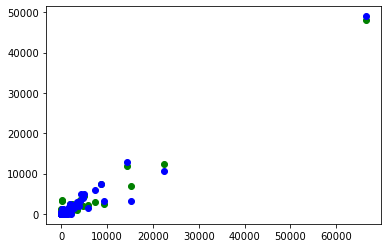

In [41]:
plt.scatter(y_test[:,0], predicted_set[:, 1], color='green')
plt.scatter(y_test[:,0], y_test[:, 1], color='blue')
plt.show()

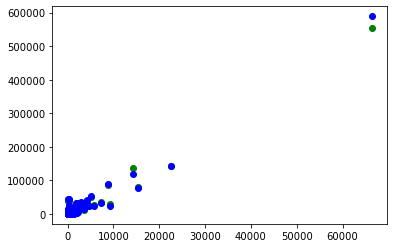

In [42]:
plt.scatter(y_test[:,0], predicted_set[:, 2], color='green')
plt.scatter(y_test[:,0], y_test[:, 2], color='blue')
plt.show()

In [43]:
missing_data = fill_nan(array.copy(), array.copy().size*0.2)

In [45]:
new_dataset = net(torch.from_numpy(missing_data.astype(float)))
new_dataset = new_dataset.detach().numpy()

In [59]:
print(distcorr(array[:, 0], array[:, 1]))
print(distcorr(array[:, 0], new_dataset[:, 1]))

0.9669590920355094
0.9368535243376688


In [60]:
print(distcorr(array[:, 0], array[:, 2]))
print(distcorr(array[:, 0], new_dataset[:, 2]))

0.9071151875162686
0.9373575429028757
